In [128]:
# !pip install plotly
import pandas as pd
# !pip install pandas_ta
import pandas_ta as ta
import numpy as np
import seaborn as sns
import datetime
from datetime import timedelta
import math
import requests
import plotly as py
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt

import sklearn as sk
import sklearn.preprocessing
from sklearn import metrics

from sklearn.preprocessing import  (StandardScaler, MinMaxScaler, LabelBinarizer)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, LogisticRegression
import xgboost as xgb
from sklearn.metrics import *
# from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import tree

from sklearn import decomposition
from sklearn.pipeline import Pipeline

# import chart_studio.tools as tls

In [129]:
#manipulatable variables
numDaysBack = str(365*5) #for daily you can go back multiple years worth, for daily you can only go back 90 days
myInterval = 'daily' # options are daily or hourly
theCoins = ['ethereum'] #can add more than one coin if you like
window_length = 14
mycom = 0.4
lower_macd_ema = 12
upper_macd_ema = 26
trigger_macd_ema = 9


def df_builder_clean(days, interval, coins, window, mycom, lower_macd_ema, upper_macd_ema, trigger_macd_ema):
    #manipulatable variables
    numDaysBack = days #for daily you can go back multiple years worth, for daily you can only go back 90 days
    myInterval = interval # options are daily or hourly
    theCoins = coins
    window_length = window

    #builds initial dataframe with ethereum as first market but just to log the dates we are working with
    geckoReq = 'https://api.coingecko.com/api/v3/coins/ethereum/market_chart?vs_currency=usd&days='+numDaysBack+'&interval='+myInterval+''
    r = requests.get(geckoReq).json()
    ts = r['prices'][0][0]
    ts = ts/1000
    HistPricesList = []
    for i in range(len(r['prices'])):
        currentUnix = r['prices'][i][0] 
        price = r['prices'][i][1]
        currentUnix = currentUnix/1000
#         currentTS = datetime.datetime.fromtimestamp(currentUnix).strftime("%d-%m-%Y %H:%M:%S") #adding dd-mm-yyyy hours minutes seconds
        currentTS = datetime.datetime.fromtimestamp(currentUnix).strftime("%m-%d-%Y") #just the date mm-dd-yyyy
        HistPricesList.append([currentTS])
    global df
    df = pd.DataFrame(HistPricesList, columns = ['date'])

    
    #looping through each coin and adding in all data points and input variables
    for coin in theCoins:
        price_data(coin)
        add_ewm(coin, mycom)
        add_rsi(coin, window_length)
        add_macd(coin, lower_macd_ema, upper_macd_ema, trigger_macd_ema)
        print('just added: ', coin)
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
#     print('r')
#     display(r)
    return df


def price_data(coin):
    global df
    # geckoReq = 'https://api.coingecko.com/api/v3/coins/ethereum/market_chart?vs_currency=usd&days=60&interval=daily'
    geckoReq = 'https://api.coingecko.com/api/v3/coins/'+coin+'/market_chart?vs_currency=usd&days='+numDaysBack+'&interval='+myInterval+''

    r = requests.get(geckoReq).json()
    ts = r['prices'][0][0]
    # print(ts)
    ts = ts/1000
    print(datetime.datetime.fromtimestamp(ts).strftime("%m-%d-%Y"))
    # print('prices length',len(r['prices']))
    HistPricesList = []
    for i in range(len(r['prices'])):
        currentUnix = r['prices'][i][0] 
        price = r['prices'][i][1]
        volume = r['total_volumes'][i][1]
        currentUnix = currentUnix/1000
        currentTS = datetime.datetime.fromtimestamp(currentUnix).strftime("%m-%d-%Y")
    #     print('price: ', price, 'TS: ', currentTS)
        HistPricesList.append([currentTS, price, volume])
    #     currentUnix = currentTS
#         print(HistPricesList)
    dfCoin = pd.DataFrame(HistPricesList, columns = ['date', coin, coin+'_volume'])
#     print('dfCoin')
#     display(dfCoin)
    df = pd.merge(df, dfCoin[coin], left_on = df['date'], right_on=dfCoin['date']).drop(['key_0'], axis = 1)
    df = pd.merge(df, dfCoin[coin+'_volume'], left_on = df['date'], right_on=dfCoin['date']).drop(['key_0'], axis = 1)
    
def add_ewm(coin, mycom):
    df[coin+'_ewm'] = df[coin].ewm(com=mycom).mean()
    
def add_rsi(coin, window_length):
    global df
    df['diff'] = df[coin].diff(1)
    df['gain'] = df['diff'].clip(lower=0).round(2)
    df['loss'] = df['diff'].clip(upper=0).abs().round(2)
    
    # Get initial Averages
    df['avg_gain'] = df['gain'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]
    df['avg_loss'] = df['loss'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]

    # Get WMS averages
    # Average Gains
    for i, row in enumerate(df['avg_gain'].iloc[window_length+1:]):
        df['avg_gain'].iloc[i + window_length + 1] =\
            (df['avg_gain'].iloc[i + window_length] *
             (window_length - 1) +
             df['gain'].iloc[i + window_length + 1])\
            / window_length
    # Average Losses
    for i, row in enumerate(df['avg_loss'].iloc[window_length+1:]):
        df['avg_loss'].iloc[i + window_length + 1] =\
            (df['avg_loss'].iloc[i + window_length] *
             (window_length - 1) +
             df['loss'].iloc[i + window_length + 1])\
            / window_length
        
    df['rs'] = df['avg_gain'] / df['avg_loss']
    
    df['rsi'] = 100 - (100 / (1.0 + df['rs']))
    df = pd.DataFrame(df)
    df = df.drop(['gain', 'loss', 'avg_loss', 'avg_gain', 'rs'], axis = 1)
    
    #renaming diff and rsi columns
    dict = {'diff': coin+'_diff',
        'rsi': coin+'_rsi'}
    df.rename(columns=dict,
              inplace=True)

def add_macd(coin, lower_macd_ema, upper_macd_ema, trigger_macd_ema):
    global df
    #get ema for lower
    k = df[coin].ewm(span=lower_macd_ema, adjust = False, min_periods = lower_macd_ema).mean()

    #get ema for upper
    d = df[coin].ewm(span=upper_macd_ema, adjust=False, min_periods=upper_macd_ema).mean()

    macd = k-d
    
    # Get the 9-Day EMA of the MACD for the Trigger line
    macd_s = macd.ewm(span=trigger_macd_ema, adjust=False, min_periods=trigger_macd_ema).mean()
    # Calculate the difference between the MACD - Trigger for the Convergence/Divergence value
    macd_h = macd - macd_s
    # Add all of our new values for the MACD to the dataframe
    df['macd'] = df.index.map(macd)
    df['macd_h'] = df.index.map(macd_h)
    df['macd_s'] = df.index.map(macd_s)



mydf = pd.DataFrame(df_builder_clean(numDaysBack, myInterval, theCoins, window_length, mycom, lower_macd_ema, upper_macd_ema, trigger_macd_ema))
display(mydf)



07-19-2017


C:\Users\fooba\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


just added:  ethereum


ethereum  ethereum_volume  ethereum_ewm  ethereum_diff  \
date                                                                    
2017-07-19   223.461348     7.317111e+08    223.461348            NaN   
2017-07-20   217.086474     3.903940e+08    218.503113      -6.374874   
2017-07-21   231.143529     2.299701e+08    227.747596      14.057055   
2017-07-22   226.718599     2.044678e+08    227.007668      -4.424930   
2017-07-23   224.913407     1.442842e+08    225.508914      -1.805192   
...                 ...              ...           ...            ...   
2022-07-14  1191.130837     1.647422e+10   1164.793901      78.210054   
2022-07-15  1234.099139     1.681719e+10   1214.297642      42.968302   
2022-07-16  1355.045640     1.902583e+10   1314.831927     120.946501   
2022-07-17  1344.720284     1.579765e+10   1336.180753     -10.325356   
2022-07-18  1487.927946     2.379816e+10   1444.571605     143.207662   

            ethereum_rsi       macd     macd_h     macd_s  
date                                                       
2017-07-19           NaN        NaN        NaN        NaN  
2017-07-20           NaN        NaN        NaN        NaN  
2017-07-21           NaN        NaN        NaN        NaN  
2017-07-22           NaN        NaN        NaN        NaN  
2017-07-23           NaN        NaN        NaN        NaN  
...                  ...        ...        ...        ...  
2022-07-14     48.359970 -58.631347  21.309137 -79.940484  
2022-07-15     51.511001 -47.361288  26.063357 -73.424645  
2022-07-16     59.079833 -28.343586  36.064847 -64.408433  
2022-07-17     58.243628 -13.944348  40.371268 -54.315616  
2022-07-18     65.528083   8.919989  50.588484 -41.668495  

[1826 rows x 8 columns]

In [130]:
mydf.dropna(inplace=True)
myCols = ['ethereum', 'ethereum_volume', 'ethereum_ewm', 'ethereum_rsi', 'macd', 'macd_h', 'macd_s', 'ethereum_diff']

In [131]:
my_data = mydf[myCols]
display(my_data)
my_data.corr()

ethereum  ethereum_volume  ethereum_ewm  ethereum_rsi  \
date                                                                   
2017-08-21   312.174471     8.983443e+08    312.869997     65.012352   
2017-08-22   316.788920     4.664746e+08    315.669228     66.393109   
2017-08-23   321.785298     3.977527e+08    320.037850     67.873967   
2017-08-24   329.025281     4.519507e+08    326.457443     69.939510   
2017-08-25   329.865783     3.338393e+08    328.891971     70.179075   
...                 ...              ...           ...           ...   
2022-07-14  1191.130837     1.647422e+10   1164.793901     48.359970   
2022-07-15  1234.099139     1.681719e+10   1214.297642     51.511001   
2022-07-16  1355.045640     1.902583e+10   1314.831927     59.079833   
2022-07-17  1344.720284     1.579765e+10   1336.180753     58.243628   
2022-07-18  1487.927946     2.379816e+10   1444.571605     65.528083   

                 macd     macd_h     macd_s  ethereum_diff  
date                                                        
2017-08-21  19.799499  -0.688150  20.487650     -10.026750  
2017-08-22  19.856092  -0.505246  20.361338       4.614450  
2017-08-23  20.072723  -0.230892  20.303615       4.996378  
2017-08-24  20.591247   0.230106  20.361141       7.239983  
2017-08-25  20.829889   0.374998  20.454891       0.840502  
...               ...        ...        ...            ...  
2022-07-14 -58.631347  21.309137 -79.940484      78.210054  
2022-07-15 -47.361288  26.063357 -73.424645      42.968302  
2022-07-16 -28.343586  36.064847 -64.408433     120.946501  
2022-07-17 -13.944348  40.371268 -54.315616     -10.325356  
2022-07-18   8.919989  50.588484 -41.668495     143.207662  

[1793 rows x 8 columns]

ethereum  ethereum_volume  ethereum_ewm  ethereum_rsi  \
ethereum         1.000000         0.532667      0.999823      0.090723   
ethereum_volume  0.532667         1.000000      0.533699      0.233339   
ethereum_ewm     0.999823         0.533699      1.000000      0.084960   
ethereum_rsi     0.090723         0.233339      0.084960      1.000000   
macd             0.184813         0.278105      0.182587      0.603716   
macd_h          -0.002328        -0.113964     -0.008067      0.394975   
macd_s           0.196453         0.329993      0.195881      0.516467   
ethereum_diff    0.030930        -0.040410      0.012923      0.234322   

                     macd    macd_h    macd_s  ethereum_diff  
ethereum         0.184813 -0.002328  0.196453       0.030930  
ethereum_volume  0.278105 -0.113964  0.329993      -0.040410  
ethereum_ewm     0.182587 -0.008067  0.195881       0.012923  
ethereum_rsi     0.603716  0.394975  0.516467       0.234322  
macd             1.000000  0.331423  0.955932       0.073050  
macd_h           0.331423  1.000000  0.039823       0.193125  
macd_s           0.955932  0.039823  1.000000       0.017269  
ethereum_diff    0.073050  0.193125  0.017269       1.000000

## Linear Regression, scaled, shift data to predict off of yesterdays info

C:\Users\fooba\anaconda3\lib\site-packages\pandas\core\generic.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(obj)
C:\Users\fooba\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


array([[-0.86717847, -0.6153973 ,  0.97155764, ..., -0.02003014,
         0.19720209, -0.13526332],
       [-0.89845127, -0.61310982,  1.069361  , ..., -0.0129955 ,
         0.19569187,  0.05161518],
       [-0.9034276 , -0.60953987,  1.17425481, ..., -0.00244367,
         0.19500171,  0.05649007],
       ...,
       [ 0.28554662,  0.12123126,  0.0152146 , ...,  1.00885165,
        -0.92564296,  0.54115915],
       [ 0.4454797 ,  0.20338586,  0.55133874, ...,  1.393516  ,
        -0.81784229,  1.53646352],
       [ 0.21171862,  0.22083169,  0.49210766, ...,  1.55914398,
        -0.69716938, -0.1390747 ]])

X_train: 
(1732, 7)
X_test: 
(60, 7)
y_train: 
(1732,)
y_test: 
(60,)
linear regression with no scaling
Root Mean squared error: 81.06
               ethereum  pred_linear_reg
date                                    
2022-05-20  1963.990940      2029.708079
2022-05-21  1978.147133      1967.029304
2022-05-22  2046.646350      1981.557598
2022-05-23  1974.581194      2044.330239
2022-05-24  1979.770545      1981.793939
2022-05-25  1944.842845      1989.457167
2022-05-26  1807.969474      1954.609963
2022-05-27  1724.875734      1831.052014
2022-05-28  1798.694855      1750.770797
2022-05-29  1814.983160      1805.396646
2022-05-30  1995.936484      1813.908938
2022-05-31  1944.078767      1987.424670
2022-06-01  1828.892655      1944.298790
2022-06-02  1833.089841      1849.419380
2022-06-03  1776.979907      1850.205268
2022-06-04  1804.261670      1791.126481
2022-06-05  1805.331395      1811.419651
2022-06-06  1860.181307      1808.860066
2022-06-07  1818.387712      1862.850491
2022

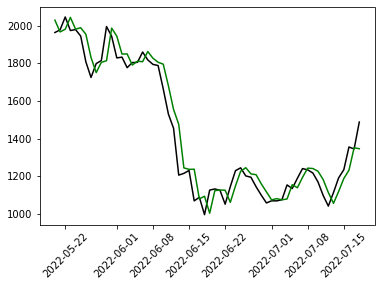

In [132]:
# X = my_data[['ethereum_volume', 'ethereum_ewm', 'ethereum_rsi', 'macd', 'ethereum_diff']]
X_raw = my_data[['ethereum_volume', 'ethereum_ewm', 'ethereum_rsi', 'macd', 'macd_h', 'macd_s', 'ethereum_diff']]
y = my_data['ethereum']
scaler=StandardScaler()
# Drop first row of prices
y.drop(index=y.index[0], 
        axis=0, 
        inplace=True)
#dropping last row of features
X_raw.drop(index=X_raw.index[-1], 
        axis=0, 
        inplace=True)
X=scaler.fit_transform(X_raw)
display(X)
# X = X.shift(1, freq='d')
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .1, random_state=42)
X_train = X[:-60]
X_test = X[-60:]
y_train = y[:-60]
y_test = y[-60:]
print('X_train: ')
print(X_train.shape)
print('X_test: ')
print(X_test.shape)
print('y_train: ')
print(y_train.shape)
print('y_test: ')
print(y_test.shape)


print('linear regression with no scaling')
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)
# The mean squared error
print("Root Mean squared error: %.2f" % math.sqrt(mean_squared_error(y_test, y_pred)))

y_check1 = pd.DataFrame(y_test)
# print(y_check1)
y_check1['pred_linear_reg']= y_pred
print(y_check1)
plt.plot(y_check1.index,y_check1['ethereum'], color = 'black')
plt.plot(y_check1.index,y_check1['pred_linear_reg'], color = 'green')
plt.xticks(rotation=45)
plt.show()

# XGBOOST SCALED Shifted 1 day

In [133]:
# X = my_data[['ethereum_volume', 'ethereum_ewm', 'ethereum_rsi', 'macd', 'ethereum_diff']]
X_raw = my_data[['ethereum_volume', 'ethereum_ewm', 'ethereum_rsi', 'macd', 'macd_h', 'macd_s', 'ethereum_diff']]
y = my_data['ethereum']
scaler=StandardScaler()
# Drop first row of prices
y.drop(index=y.index[0], 
        axis=0, 
        inplace=True)
#dropping last row of features
X_raw.drop(index=X_raw.index[-1], 
        axis=0, 
        inplace=True)
X=scaler.fit_transform(X_raw)
display(X)
# X = X.shift(1, freq='d')
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .1, random_state=42)
X_train = X[:-60]
X_test = X[-60:]
y_train = y[:-60]
y_test = y[-60:]
print('X_train: ')
print(X_train.shape)
print('X_test: ')
print(X_test.shape)
print('y_train: ')
print(y_train.shape)
print('y_test: ')
print(y_test.shape)

xg_reg=xgb.XGBRegressor(objective='reg:squarederror',colsample_bytree=0.3, learning_rate=0.1,
                        max_depth=5,alpha=10,n_estimators=10)
xg_reg.fit(X_train,y_train)
preds=xg_reg.predict(X_test)
rmse=np.sqrt(mean_squared_error(y_test,preds))
# print(preds)
# print(y_check1)
print('xgb rmse: ', rmse)
# y_check1['pred_xgb']= preds
# plt.plot(y_check1.index,y_check1['ethereum'], color = 'black')
# plt.plot(y_check1.index,y_check1['pred_linear_reg'], color = 'green')
# plt.plot(y_check1.index,y_check1['pred_xgb'], color = 'blue')
# plt.xticks(rotation=45)
# plt.show()

C:\Users\fooba\anaconda3\lib\site-packages\pandas\core\generic.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(obj)
C:\Users\fooba\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


array([[-0.86717847, -0.6153973 ,  0.97155764, ..., -0.02003014,
         0.19720209, -0.13526332],
       [-0.89845127, -0.61310982,  1.069361  , ..., -0.0129955 ,
         0.19569187,  0.05161518],
       [-0.9034276 , -0.60953987,  1.17425481, ..., -0.00244367,
         0.19500171,  0.05649007],
       ...,
       [ 0.28554662,  0.12123126,  0.0152146 , ...,  1.00885165,
        -0.92564296,  0.54115915],
       [ 0.4454797 ,  0.20338586,  0.55133874, ...,  1.393516  ,
        -0.81784229,  1.53646352],
       [ 0.21171862,  0.22083169,  0.49210766, ...,  1.55914398,
        -0.69716938, -0.1390747 ]])

X_train: 
(1732, 7)
X_test: 
(60, 7)
y_train: 
(1732,)
y_test: 
(60,)
xgb rmse:  379.4992534443113


In [134]:
mydf['pct_chg'] = mydf['ethereum_diff']/mydf['ethereum']
mydf['swing'] = (mydf['pct_chg']>.02).astype(int)
display(mydf)
print(mydf['swing'].value_counts())

ethereum  ethereum_volume  ethereum_ewm  ethereum_diff  \
date                                                                    
2017-08-21   312.174471     8.983443e+08    312.869997     -10.026750   
2017-08-22   316.788920     4.664746e+08    315.669228       4.614450   
2017-08-23   321.785298     3.977527e+08    320.037850       4.996378   
2017-08-24   329.025281     4.519507e+08    326.457443       7.239983   
2017-08-25   329.865783     3.338393e+08    328.891971       0.840502   
...                 ...              ...           ...            ...   
2022-07-14  1191.130837     1.647422e+10   1164.793901      78.210054   
2022-07-15  1234.099139     1.681719e+10   1214.297642      42.968302   
2022-07-16  1355.045640     1.902583e+10   1314.831927     120.946501   
2022-07-17  1344.720284     1.579765e+10   1336.180753     -10.325356   
2022-07-18  1487.927946     2.379816e+10   1444.571605     143.207662   

            ethereum_rsi       macd     macd_h     macd_s   pct_chg  swing  
date                                                                        
2017-08-21     65.012352  19.799499  -0.688150  20.487650 -0.032119      0  
2017-08-22     66.393109  19.856092  -0.505246  20.361338  0.014566      0  
2017-08-23     67.873967  20.072723  -0.230892  20.303615  0.015527      0  
2017-08-24     69.939510  20.591247   0.230106  20.361141  0.022004      1  
2017-08-25     70.179075  20.829889   0.374998  20.454891  0.002548      0  
...                  ...        ...        ...        ...       ...    ...  
2022-07-14     48.359970 -58.631347  21.309137 -79.940484  0.065660      1  
2022-07-15     51.511001 -47.361288  26.063357 -73.424645  0.034818      1  
2022-07-16     59.079833 -28.343586  36.064847 -64.408433  0.089256      1  
2022-07-17     58.243628 -13.944348  40.371268 -54.315616 -0.007678      0  
2022-07-18     65.528083   8.919989  50.588484 -41.668495  0.096246      1  

[1793 rows x 10 columns]

0    1251
1     542
Name: swing, dtype: int64


In [135]:
mydf.corr()

ethereum  ethereum_volume  ethereum_ewm  ethereum_diff  \
ethereum         1.000000         0.532667      0.999823       0.030930   
ethereum_volume  0.532667         1.000000      0.533699      -0.040410   
ethereum_ewm     0.999823         0.533699      1.000000       0.012923   
ethereum_diff    0.030930        -0.040410      0.012923       1.000000   
ethereum_rsi     0.090723         0.233339      0.084960       0.234322   
macd             0.184813         0.278105      0.182587       0.073050   
macd_h          -0.002328        -0.113964     -0.008067       0.193125   
macd_s           0.196453         0.329993      0.195881       0.017269   
pct_chg          0.018528        -0.002622      0.006480       0.662933   
swing            0.064250         0.116252      0.055343       0.495241   

                 ethereum_rsi      macd    macd_h    macd_s   pct_chg  \
ethereum             0.090723  0.184813 -0.002328  0.196453  0.018528   
ethereum_volume      0.233339  0.278105 -0.113964  0.329993 -0.002622   
ethereum_ewm         0.084960  0.182587 -0.008067  0.195881  0.006480   
ethereum_diff        0.234322  0.073050  0.193125  0.017269  0.662933   
ethereum_rsi         1.000000  0.603716  0.394975  0.516467  0.348610   
macd                 0.603716  1.000000  0.331423  0.955932  0.058879   
macd_h               0.394975  0.331423  1.000000  0.039823  0.140741   
macd_s               0.516467  0.955932  0.039823  1.000000  0.018562   
pct_chg              0.348610  0.058879  0.140741  0.018562  1.000000   
swing                0.273657  0.048077  0.050479  0.035209  0.644748   

                    swing  
ethereum         0.064250  
ethereum_volume  0.116252  
ethereum_ewm     0.055343  
ethereum_diff    0.495241  
ethereum_rsi     0.273657  
macd             0.048077  
macd_h           0.050479  
macd_s           0.035209  
pct_chg          0.644748  
swing            1.000000

In [136]:
# X = my_data[['ethereum_volume', 'ethereum_ewm', 'ethereum_rsi', 'macd', 'ethereum_diff']]
X_raw = mydf[['ethereum_volume', 'ethereum_ewm', 'ethereum_rsi', 'macd', 'macd_h', 'macd_s']]
y = mydf['swing']
scaler=StandardScaler()
# Drop first row of prices
y.drop(index=y.index[0], 
        axis=0, 
        inplace=True)
#dropping last row of features
X_raw.drop(index=X_raw.index[-1], 
        axis=0, 
        inplace=True)
X=scaler.fit_transform(X_raw)
display(X)
# X = X.shift(1, freq='d')
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .1, random_state=42)
X_train = X[:-60]
X_test = X[-60:]
y_train = y[:-60]
y_test = y[-60:]
print('X_train: ')
print(X_train.shape)
print('X_test: ')
print(X_test.shape)
print('y_train: ')
print(y_train.shape)
print('y_test: ')
print(y_test.shape)

xg_reg=xgb.XGBRegressor(objective='reg:squarederror',colsample_bytree=0.3, learning_rate=0.1,
                        max_depth=5,alpha=10,n_estimators=10)
xg_reg.fit(X_train,y_train)
y_test_pred=xg_reg.predict(X_test)
rmse=np.sqrt(mean_squared_error(y_test,y_test_pred))
print(y_test_pred)
# print(y_check1)
print(rmse)

C:\Users\fooba\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


array([[-0.86717847, -0.6153973 ,  0.97155764,  0.18031   , -0.02003014,
         0.19720209],
       [-0.89845127, -0.61310982,  1.069361  ,  0.18094886, -0.0129955 ,
         0.19569187],
       [-0.9034276 , -0.60953987,  1.17425481,  0.18339431, -0.00244367,
         0.19500171],
       ...,
       [ 0.28554662,  0.12123126,  0.0152146 , -0.57784112,  1.00885165,
        -0.92564296],
       [ 0.4454797 ,  0.20338586,  0.55133874, -0.36315792,  1.393516  ,
        -0.81784229],
       [ 0.21171862,  0.22083169,  0.49210766, -0.20061072,  1.55914398,
        -0.69716938]])

X_train: 
(1732, 6)
X_test: 
(60, 6)
y_train: 
(1732,)
y_test: 
(60,)
[0.42156172 0.42388126 0.4134042  0.4134042  0.4134042  0.3930102
 0.3930102  0.41481954 0.41481954 0.3930102  0.3930102  0.3930102
 0.3930102  0.4176191  0.3930102  0.3930102  0.3930102  0.3930102
 0.3930102  0.41481954 0.3930102  0.3930102  0.3930102  0.4176191
 0.41481954 0.44384304 0.44384304 0.44384304 0.42973316 0.42973316
 0.4515425  0.44337106 0.42156172 0.42388126 0.4134042  0.4134042
 0.3930102  0.3930102  0.3930102  0.3930102  0.3930102  0.3930102
 0.3930102  0.3930102  0.3930102  0.3930102  0.3930102  0.3930102
 0.37981775 0.37981775 0.37981775 0.37981775 0.35656506 0.35656506
 0.35656506 0.35656506 0.35656506 0.35656506 0.35656506 0.35656506]
0.4635861507220003


In [137]:
X_raw = mydf[['ethereum_volume', 'ethereum_ewm', 'ethereum_rsi', 'macd', 'macd_h', 'macd_s']]
y = mydf['swing']
scaler=StandardScaler()
# Drop first row of prices
y.drop(index=y.index[0], 
        axis=0, 
        inplace=True)
#dropping last row of features
X_raw.drop(index=X_raw.index[-1], 
        axis=0, 
        inplace=True)
X=scaler.fit_transform(X_raw)
display(X)
# X = X.shift(1, freq='d')
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .1, random_state=42)
X_train = X[:-60]
X_test = X[-60:]
y_train = y[:-60]
y_test = y[-60:]
print('X_train: ')
print(X_train.shape)
print('X_test: ')
print(X_test.shape)
print('y_train: ')
print(y_train.shape)
print('y_test: ')
print(y_test.shape)

C:\Users\fooba\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


array([[-0.86717847, -0.6153973 ,  0.97155764,  0.18031   , -0.02003014,
         0.19720209],
       [-0.89845127, -0.61310982,  1.069361  ,  0.18094886, -0.0129955 ,
         0.19569187],
       [-0.9034276 , -0.60953987,  1.17425481,  0.18339431, -0.00244367,
         0.19500171],
       ...,
       [ 0.28554662,  0.12123126,  0.0152146 , -0.57784112,  1.00885165,
        -0.92564296],
       [ 0.4454797 ,  0.20338586,  0.55133874, -0.36315792,  1.393516  ,
        -0.81784229],
       [ 0.21171862,  0.22083169,  0.49210766, -0.20061072,  1.55914398,
        -0.69716938]])

X_train: 
(1732, 6)
X_test: 
(60, 6)
y_train: 
(1732,)
y_test: 
(60,)


In [138]:
# print(y_train)
print(y_train.value_counts())
print(y_test.value_counts())

clf_d = tree.DecisionTreeClassifier(max_depth=4,
#                                     class_weight={0: 1, 1: 8},
                                    random_state=42
                                    )

clf_d = clf_d.fit(X_train, y_train)

y_train_pred = clf_d.predict(X_train)
y_test_pred = clf_d.predict(X_test)
# print
print(confusion_matrix(y_test, y_test_pred))
print('accuracy score of test: ' + str(accuracy_score(y_test, y_test_pred)))
print('y_train confusion matrix')
print(confusion_matrix(y_train, y_train_pred))
print(['TN', 'FN'],'\n ',['FP', 'TP'])

0    1205
1     527
Name: swing, dtype: int64
0    45
1    15
Name: swing, dtype: int64
[[45  0]
 [15  0]]
accuracy score of test: 0.75
y_train confusion matrix
[[1142   63]
 [ 438   89]]
['TN', 'FN'] 
  ['FP', 'TP']


In [139]:
clf_c = tree.DecisionTreeClassifier(max_depth=4,
                                    # max_features='auto', 
                                    # max_leaf_nodes=None,
                                    # min_samples_leaf=1,
                                    # min_weight_fraction_leaf=0.1,
                                    # splitter='best',
                                    random_state=42
                                    )

clf_c.fit(X_train, y_train)
params={"splitter":["best"],
        "max_depth" : [1,2,3,4,5],
        "min_samples_leaf":[1,2,3,4,5,6,7],
        "min_weight_fraction_leaf":[0.1,0.25,0.5],
        "max_features":["auto","log2","sqrt",None],
        "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90]
        }
3
tuning_model=GridSearchCV(estimator=clf_c,param_grid=params,scoring='precision_macro',cv=3,verbose=3)
tuning_model.fit(X_train, y_train) 
tuning_model.best_params_

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

Fitting 3 folds for each of 4200 candidates, totalling 12600 fits
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.25, 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_de

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_dep

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_dept

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s


C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s


C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s


C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s


C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s


C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s


C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s


C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s


C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_feat

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s


C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s


C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s


C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s


C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s


C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=90, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=90, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=90, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=90, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=90, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=90, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_dep

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_feat

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_feat

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=80, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=80, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=80, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=80, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=80, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=80, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=90, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=90, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=90, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=90, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=90, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=90, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_de

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_dept

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1,

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_feat

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=90, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=90, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=90, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=1, max_feat

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=2, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_dept

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=2, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=2, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=2, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=2, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=2, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=2, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_feat

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=2, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=2, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=2, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=2, max_features=auto, max_leaf_nodes=90, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=auto, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=auto, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=auto, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=auto, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=auto, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=2, max_features=log2, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=log2, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=log2, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=log2, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=log2, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=log2, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_de

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=2, max_features=log2, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=log2, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=log2, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=log2, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=log2, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=log2, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_feat

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=2, max_features=log2, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=log2, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=log2, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=log2, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=log2, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=log2, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=2, max_features=log2, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=log2, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=log2, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=log2, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=log2, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=log2, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_feat

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=2, max_features=log2, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=log2, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=log2, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=log2, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=log2, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=log2, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=2, max_features=log2, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=log2, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=log2, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=log2, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=log2, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=log2, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=2, max_features=log2, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=log2, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=log2, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=log2, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=log2, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=log2, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=2, max_features=log2, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=log2, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=log2, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=log2, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=log2, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=log2, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=2, max_features=log2, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=log2, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=log2, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=log2, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=log2, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=log2, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=2, max_features=log2, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=log2, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=log2, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=log2, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=log2, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=log2, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=2, max_features=log2, max_leaf_nodes=80, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=log2, max_leaf_nodes=80, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=log2, max_leaf_nodes=80, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=log2, max_leaf_nodes=80, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=log2, max_leaf_nodes=80, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=log2, max_leaf_nodes=80, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=2, max_features=log2, max_leaf_nodes=90, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=log2, max_leaf_nodes=90, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=log2, max_leaf_nodes=90, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=log2, max_leaf_nodes=90, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=log2, max_leaf_nodes=90, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=log2, max_leaf_nodes=90, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_de

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_feat

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=2, max_features=None, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=None, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=None, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=None, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=None, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=None, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_de

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=2, max_features=None, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=None, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=None, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=None, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=None, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=None, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=2, max_features=None, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=None, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=None, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=None, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=None, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=None, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=2, max_features=None, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=None, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=None, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=None, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=None, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=None, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_feat

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=2, max_features=None, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=None, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=None, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=None, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=None, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=None, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=2, max_features=None, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=None, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=None, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=None, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=None, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=None, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=2, max_features=None, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=None, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=None, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=None, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=None, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=None, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=2, max_features=None, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=None, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=None, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=None, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=None, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=None, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_feat

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=2, max_features=None, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=None, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=None, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=None, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=None, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=None, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=2, max_features=None, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=None, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=None, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=None, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=None, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=None, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=2, max_features=None, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=None, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=None, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=None, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=None, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=None, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=2, max_features=None, max_leaf_nodes=80, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=None, max_leaf_nodes=80, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=None, max_leaf_nodes=80, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=None, max_leaf_nodes=80, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=None, max_leaf_nodes=90, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=None, max_leaf_nodes=90, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=2, max_features=None, max_leaf_nodes=90, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=None, max_leaf_nodes=90, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=None, max_leaf_nodes=90, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_features=None, max_leaf_nodes=90, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=2, max_features=None, max_leaf_nodes=90, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=2, max_features=None, max_leaf_nodes=90, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=2, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_dept

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_feat

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_feat

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=90, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_dept

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=90, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=90, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=90, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=90, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_de

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, ma

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_feat

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_feat

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_dept

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_feat

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=80, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=80, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=80, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=80, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=80, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=80, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=90, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=90, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=90, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=90, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=90, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=90, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=90, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=90, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=90, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=90, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=90, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=90, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=3, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=4, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_dept

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=4, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=4, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=4, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_feat

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=4, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=4, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=4, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=4, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=4, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=4, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=4, max_features=auto, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=auto, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=auto, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=auto, max_leaf_nodes=90, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=auto, max_leaf_nodes=90, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=auto, max_leaf_nodes=90, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_feat

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=4, max_features=log2, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=log2, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=log2, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=log2, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=log2, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=log2, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_dept

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=4, max_features=log2, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=log2, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=log2, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=log2, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=log2, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=log2, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_dep

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=4, max_features=log2, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=log2, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=log2, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=log2, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=log2, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=log2, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=4, max_features=log2, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=log2, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=log2, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=log2, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=log2, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=log2, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_feat

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=4, max_features=log2, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=log2, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=log2, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=log2, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=log2, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=log2, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=4, max_features=log2, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=log2, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=log2, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=log2, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=log2, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=log2, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=4, max_features=log2, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=log2, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=log2, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=log2, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=log2, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=log2, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_feat

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=4, max_features=log2, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=log2, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=log2, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=log2, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=log2, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=log2, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_feat

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=4, max_features=log2, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=log2, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=log2, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=log2, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=log2, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=log2, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=4, max_features=log2, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=log2, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=log2, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=log2, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=log2, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=log2, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=4, max_features=log2, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=log2, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=log2, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=log2, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=log2, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=log2, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=4, max_features=log2, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=log2, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=log2, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=log2, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=log2, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=log2, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=4, max_features=log2, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=log2, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=log2, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=log2, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=log2, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=log2, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=4, max_features=log2, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=log2, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=log2, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=log2, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=log2, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=log2, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_feat

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=4, max_features=log2, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=log2, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=log2, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=log2, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=log2, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=log2, max_leaf_nodes=90, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_de

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_dept

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_feat

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=4, max_features=None, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=None, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=None, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=None, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=None, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=None, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_de

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=4, max_features=None, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=None, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=None, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=None, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=None, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=None, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=4, max_features=None, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=None, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=None, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=None, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=None, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=None, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=4, max_features=None, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=None, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=None, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=None, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=None, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=None, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=4, max_features=None, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=None, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=None, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=None, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=None, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=None, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=4, max_features=None, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=None, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=None, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=None, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=None, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=None, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=4, max_features=None, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=None, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=None, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=None, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=None, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=None, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=4, max_features=None, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=None, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=None, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=None, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=None, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=None, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_feat

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=4, max_features=None, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=None, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=None, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=None, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=None, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=None, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=4, max_features=None, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=None, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=None, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=None, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=None, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=None, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM


[CV 3/3] END max_depth=4, max_features=None, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=None, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=None, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=None, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=None, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=None, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=4, max_features=None, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=None, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=None, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=None, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=None, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=None, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=4, max_features=None, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=None, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=None, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=None, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=None, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=None, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=4, max_features=None, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=None, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=None, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=None, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=None, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=None, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=4, max_features=None, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=None, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=None, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=None, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=None, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=None, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=4, max_features=None, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=None, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=None, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=None, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=None, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=None, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=4, max_features=None, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=None, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=None, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_features=None, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=4, max_features=None, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=4, max_features=None, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=4, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=80, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=80, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=80, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=80, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=80, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=80, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=90, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=90, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=90, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=90, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=90, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=90, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_dept

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=90, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_de

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_dep

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_feat

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_de

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_fea

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_fe

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_feat

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=90, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=90, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=90, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=90, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.348 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=90, min_samples_leaf=1, min_weight_fraction_leaf=0.25, splitter=best;, score=0.347 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=90, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=0.348 total time=   0.0s
[CV 2/3] END max_depth=5, max_f

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

{'max_depth': 1,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_samples_leaf': 1,
 'min_weight_fraction_leaf': 0.1,
 'splitter': 'best'}

In [140]:
clf_c = tree.DecisionTreeClassifier(max_depth=1,
                                    max_features='auto', 
                                    max_leaf_nodes=None,
                                    min_samples_leaf=1,
                                    min_weight_fraction_leaf=0.1,
                                    splitter='best',
                                    random_state=42
                                    )

clf_c.fit(X_train, y_train)
y_train_pred = clf_c.predict(X_train)
y_test_pred = clf_c.predict(X_test)
print(confusion_matrix(y_test, y_test_pred))
print('accuracy score of test: ' + str(accuracy_score(y_test, y_test_pred)))

print(['TN', 'FN'],'\n ',['FP', 'TP'])

[[45  0]
 [15  0]]
accuracy score of test: 0.75
['TN', 'FN'] 
  ['FP', 'TP']


In [141]:
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_we

In [142]:
logr = LogisticRegression(max_iter=10000)

logr = logr.fit(X_train,y_train)

y_test_pred = logr.predict(X_test)
y_train_pred = logr.predict(X_train)

print('ALPHA MODEL')
print('accuracy score of training: ' + str(accuracy_score(y_train, y_train_pred)))
print('accuracy score of test: ' + str(accuracy_score(y_test, y_test_pred)))
print('error score of training: ' + str(zero_one_loss(y_train, y_train_pred)))
print('error score of test: ' + str(zero_one_loss(y_test, y_test_pred)))
print()
print('training confusion matrix:')
print(confusion_matrix(y_train, y_train_pred))
print('test confusion matrix:')
print(confusion_matrix(y_test, y_test_pred))
print()
print('training precision:')
print(precision_score(y_train, y_train_pred))
print('test precision:')
print(precision_score(y_test, y_test_pred))
print('training recall:')
print(recall_score(y_train, y_train_pred))
print('test recall:')
print(recall_score(y_test, y_test_pred))
print('training f1:')
print(f1_score(y_train, y_train_pred))
print('test f1:')
print(f1_score(y_test, y_test_pred))

ALPHA MODEL
accuracy score of training: 0.6963048498845266
accuracy score of test: 0.75
error score of training: 0.30369515011547343
error score of test: 0.25

training confusion matrix:
[[1199    6]
 [ 520    7]]
test confusion matrix:
[[45  0]
 [15  0]]

training precision:
0.5384615384615384
test precision:
0.0
training recall:
0.013282732447817837
test recall:
0.0
training f1:
0.025925925925925925
test f1:
0.0


C:\Users\fooba\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [143]:
pca = decomposition.PCA()

logr = LogisticRegression(max_iter=10000)

pipe = Pipeline(steps=[('pca', pca), ('logistic_Reg', logr)])

n_components = list(range(1,X_train.shape[1]+1,1))

C = np.logspace(-4, 4, 50)
penalty = ['l1', 'l2']

parameters = dict(pca__n_components=n_components,
                    logistic_Reg__C=C,
                    logistic_Reg__penalty=penalty)

clf_logr_gs = GridSearchCV(pipe, parameters)

clf_logr_gs.fit(X_train, y_train)

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fooba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\Users\fooba\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
 0.69572887 0.69572887 0.69572887 0.69572887 0.69572887 0.69572887
        nan        nan        nan        nan        nan        nan
 0.69572887 0.69572887 0.69572887 0.69572887 0.69572887 0.69572887
        nan        nan        nan        nan        nan        nan
 0.69572887 0.69572887 0.69572887 0.69572887 0.69572887 0.69572887
        nan        nan        nan        nan        nan        nan
 0.69572887 0.69572887 0.69572887 0.69572887 0.69572887 0.69572887
        nan        nan        nan        nan        nan        nan
 0.69572887 0.69572887 0.69572887 0.69572887 0.69572887 0.69572887
        nan        nan        nan        nan        nan        nan
 0.69572887 0.69572887 0.69572887 0.69572887 0.69572887 0.69572887
        nan        nan        nan        nan        n

GridSearchCV(estimator=Pipeline(steps=[('pca', PCA()),
                                       ('logistic_Reg',
                                        LogisticRegression(max_iter=10000))]),
             param_grid={'logistic_Reg__C': array([1.00000000e-04, 1.45634848e-04, 2.12095089e-04, 3.08884360e-04,
       4.49843267e-04, 6.55128557e-04, 9.54095476e-04, 1.38949549e-03,
       2.02358965e-03, 2.94705170e-03, 4.29193426e-03, 6.25055193e-03,
       9.10298178e-03, 1.32571137e...
       3.72759372e+00, 5.42867544e+00, 7.90604321e+00, 1.15139540e+01,
       1.67683294e+01, 2.44205309e+01, 3.55648031e+01, 5.17947468e+01,
       7.54312006e+01, 1.09854114e+02, 1.59985872e+02, 2.32995181e+02,
       3.39322177e+02, 4.94171336e+02, 7.19685673e+02, 1.04811313e+03,
       1.52641797e+03, 2.22299648e+03, 3.23745754e+03, 4.71486636e+03,
       6.86648845e+03, 1.00000000e+04]),
                         'logistic_Reg__penalty': ['l1', 'l2'],
                         'pca__n_components': [1, 2, 3,

In [144]:
print('Best Penalty:', clf_logr_gs.best_estimator_.get_params()['logistic_Reg__penalty'])
print('Best C:', clf_logr_gs.best_estimator_.get_params()['logistic_Reg__C'])
print('Best Number Of Components:', clf_logr_gs.best_estimator_.get_params()['pca__n_components'])
print(); print(clf_logr_gs.best_estimator_.get_params()['logistic_Reg'])


Best Penalty: l2
Best C: 0.009102981779915217
Best Number Of Components: 5

LogisticRegression(C=0.009102981779915217, max_iter=10000)


In [145]:
clf_logr_gs.best_estimator_.get_params()

{'memory': None,
 'steps': [('pca', PCA(n_components=5)),
  ('logistic_Reg',
   LogisticRegression(C=0.009102981779915217, max_iter=10000))],
 'verbose': False,
 'pca': PCA(n_components=5),
 'logistic_Reg': LogisticRegression(C=0.009102981779915217, max_iter=10000),
 'pca__copy': True,
 'pca__iterated_power': 'auto',
 'pca__n_components': 5,
 'pca__random_state': None,
 'pca__svd_solver': 'auto',
 'pca__tol': 0.0,
 'pca__whiten': False,
 'logistic_Reg__C': 0.009102981779915217,
 'logistic_Reg__class_weight': None,
 'logistic_Reg__dual': False,
 'logistic_Reg__fit_intercept': True,
 'logistic_Reg__intercept_scaling': 1,
 'logistic_Reg__l1_ratio': None,
 'logistic_Reg__max_iter': 10000,
 'logistic_Reg__multi_class': 'auto',
 'logistic_Reg__n_jobs': None,
 'logistic_Reg__penalty': 'l2',
 'logistic_Reg__random_state': None,
 'logistic_Reg__solver': 'lbfgs',
 'logistic_Reg__tol': 0.0001,
 'logistic_Reg__verbose': 0,
 'logistic_Reg__warm_start': False}